# Análisis de sentimientos sobre la compra de Twitter por parte de Elon Musk
## Objetivos
1. Trabajar con Twitter API para obtener Tweets.
2. Limpiar los miles de tweets para poder analizarlos.
3. Realizar análisis de sentimientos y evaluar impacto
    - Graficar número de interacciones que tienen los tweets de cada sentimiento
    - Visualizar nubes de palabras y conjuntos de palabras frecuentes.

In [4]:
# Import Libraries
import tweepy
import config
from textblob import TextBlob
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import re
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# API KEYS and REQUESTS
auth = tweepy.OAuthHandler(config.CONSUMER_KEY, config.CONSUMER_SECRET)
auth.set_access_token(config.ACCESS_TOKEN, config.ACCESS_TOKE_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)
client = tweepy.Client(bearer_token=config.BEARER_TOKEN)

In [12]:
query = "twitter ((elon musk) OR elon) -is:retweet lang:en"

In [ ]:
# To print the complete tweet text with the public stats obtained use this
# Para imprimr la información completa de los tweets usar esto
tweet_list = []
for tweet in tweepy.Paginator(client.search_recent_tweets, query=query, max_results=100, tweet_fields=['created_at','lang', 'public_metrics']).flatten(limit=5000):
    tweet_list.append(tweet)
    print(f'ID: {tweet.id} : {tweet.text}')
    # print(tweet.text)
    print(tweet.public_metrics)

In [34]:
# df = pd.DataFrame(columns=['id','text','created_at','retweet_count','like_count'])
tweet_list2 = []
for tweet in tweet_list:
    tweet_list2.append([tweet.id, tweet.text, tweet.created_at, tweet.public_metrics['retweet_count'], tweet.public_metrics['like_count']])
df = pd.DataFrame(tweet_list2)
df.columns = ['id','text','created_at','retweet_count','like_count']
df.head()

,id,text,created_at,retweet_count,like_count
0,1596788283006423041,TWITTER THESE DAYS IS THE SAME AS A BROTHEL.\n...,2022-11-27 08:49:28+00:00,0,0
1,1596788280179437568,@DruhFarrell Is this real? Are you a real per...,2022-11-27 08:49:27+00:00,0,0
2,1596788230162087937,Elon Musk Plans to Launch Alternative Phone if...,2022-11-27 08:49:15+00:00,0,0
3,1596788227045588994,"Twitter 2.0 to roll out encrypted DMs, long-fo...",2022-11-27 08:49:14+00:00,0,0
4,1596788221941534720,@iamtomnash One sad reality is if twitter real...,2022-11-27 08:49:13+00:00,0,0


In [53]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = df
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,id,text,created_at,retweet_count,like_count
0,1596788283006423041,twitter these days is the same as a brothel ...,2022-11-27 08:49:28+00:00,0,0
1,1596788280179437568,is this real are you a real person i th...,2022-11-27 08:49:27+00:00,0,0
2,1596788230162087937,elon musk plans to launch alternative phone if...,2022-11-27 08:49:15+00:00,0,0
3,1596788227045588994,twitter 2 0 to roll out encrypted dms long fo...,2022-11-27 08:49:14+00:00,0,0
4,1596788221941534720,one sad reality is if twitter really working...,2022-11-27 08:49:13+00:00,0,0
5,1596788218795503616,is this true just over a week after taki...,2022-11-27 08:49:12+00:00,0,0
6,1596788218439307265,elon musk spinning up 50 high end gpus to solv...,2022-11-27 08:49:12+00:00,0,0
7,1596788214827606016,i love elon,2022-11-27 08:49:11+00:00,0,0
8,1596788200475099138,low payment long hours and being treate...,2022-11-27 08:49:08+00:00,0,0
9,1596788174856286209,strange things going on people seem to want...,2022-11-27 08:49:02+00:00,0,0


In [55]:
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'compound'] = comp

tw_list.head(10)

,id,text,created_at,retweet_count,like_count,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,1596788283006423041,twitter these days is the same as a brothel ...,2022-11-27 08:49:28+00:00,0,0,0.000000,0.125000,negative,0.083,0.876,0.041,-0.3612
1,1596788280179437568,is this real are you a real person i th...,2022-11-27 08:49:27+00:00,0,0,0.200000,0.300000,neutral,0.000,1.000,0.000,0.0000
2,1596788230162087937,elon musk plans to launch alternative phone if...,2022-11-27 08:49:15+00:00,0,0,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
3,1596788227045588994,twitter 2 0 to roll out encrypted dms long fo...,2022-11-27 08:49:14+00:00,0,0,-0.050000,0.400000,neutral,0.000,1.000,0.000,0.0000
4,1596788221941534720,one sad reality is if twitter really working...,2022-11-27 08:49:13+00:00,0,0,0.154167,0.550000,negative,0.154,0.743,0.103,-0.2551
5,1596788218795503616,is this true just over a week after taki...,2022-11-27 08:49:12+00:00,0,0,0.306250,0.631250,positive,0.047,0.885,0.069,0.2263
6,1596788218439307265,elon musk spinning up 50 high end gpus to solv...,2022-11-27 08:49:12+00:00,0,0,0.160000,0.540000,positive,0.000,0.859,0.141,0.2023
7,1596788214827606016,i love elon,2022-11-27 08:49:11+00:00,0,0,0.500000,0.600000,positive,0.000,0.192,0.808,0.6369
8,1596788200475099138,low payment long hours and being treate...,2022-11-27 08:49:08+00:00,0,0,0.062500,0.525000,positive,0.199,0.490,0.311,0.4939
9,1596788174856286209,strange things going on people seem to want...,2022-11-27 08:49:02+00:00,0,0,0.029167,0.409722,negative,0.105,0.809,0.086,-0.1685


In [56]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [70]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [168]:
n5_bigrams = get_top_n_gram(tw_list['text'],(5,5),20)

n5_bigrams

[('elon musk twitter censor accurate', 52),
 ('musk twitter censor accurate information', 52),
 ('alternative phone apple google boot', 39),
 ('phone apple google boot twitter', 39),
 ('apple google boot twitter app', 39),
 ('google boot twitter app stores', 38),
 ('launch alternative phone apple google', 32),
 ('twitter censor accurate information 2022', 32),
 ('elon musk plans launch alternative', 30),
 ('plans launch alternative phone apple', 30),
 ('censor accurate information 2022 11', 30),
 ('musk plans launch alternative phone', 29),
 ('need reply elon need badly', 27),
 ('reply elon need badly reply', 27),
 ('elon need badly reply elon', 27),
 ('need badly reply elon need', 27),
 ('badly reply elon need minutes', 27),
 ('reply elon need minutes elon', 27),
 ('elon musk claims time high', 19),
 ('musk claims time high new', 19)]

## Negative Sentiment WordCloud

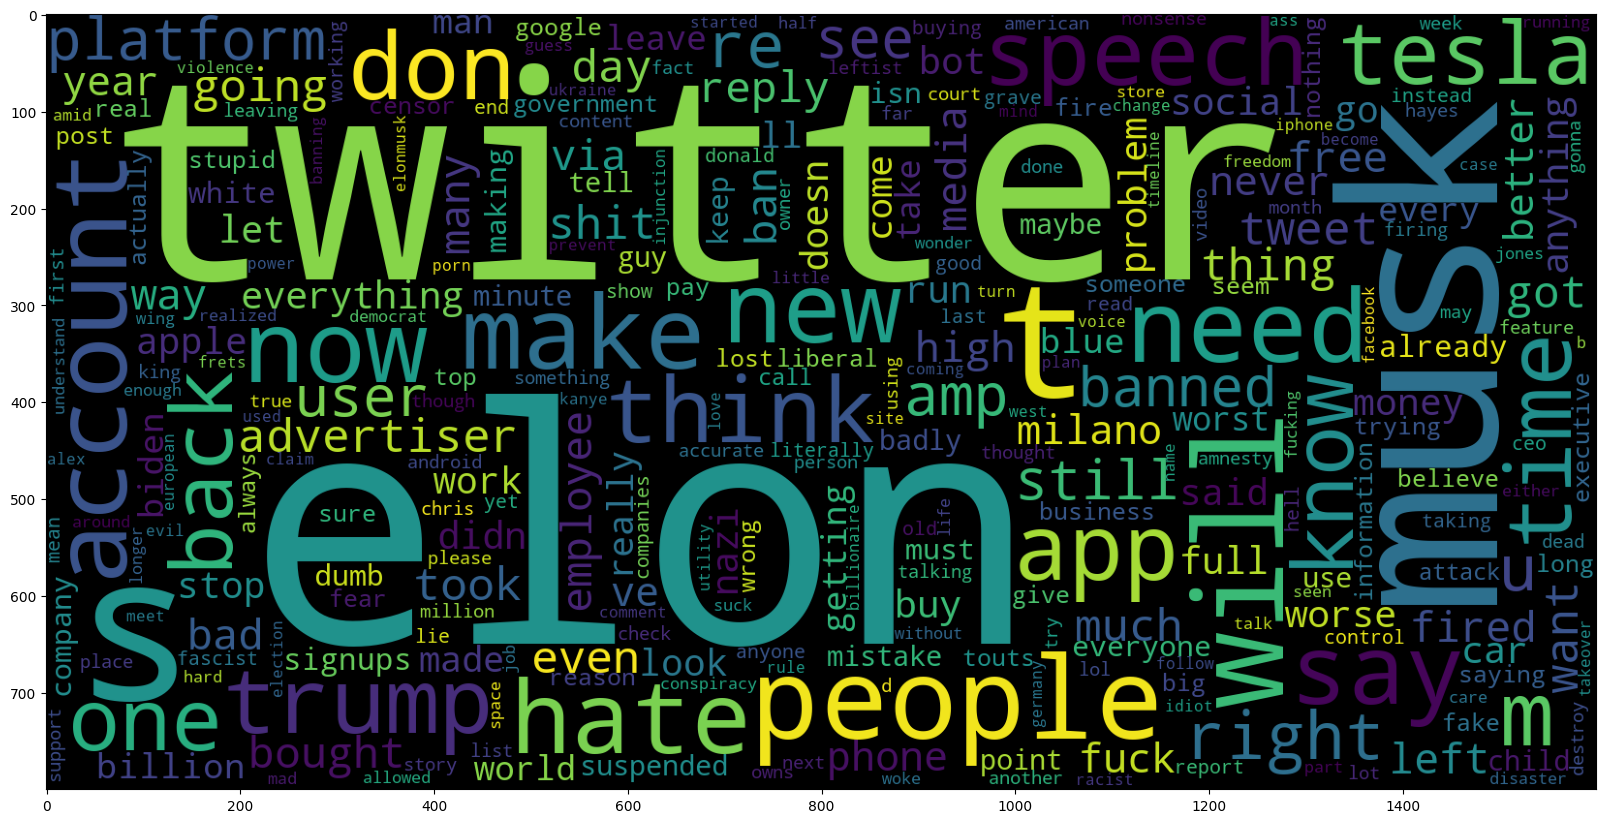

In [90]:
data_pos = tw_list_negative['text']
wc = WordCloud(max_words = 300 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


### Positive Sentiment WordCloud

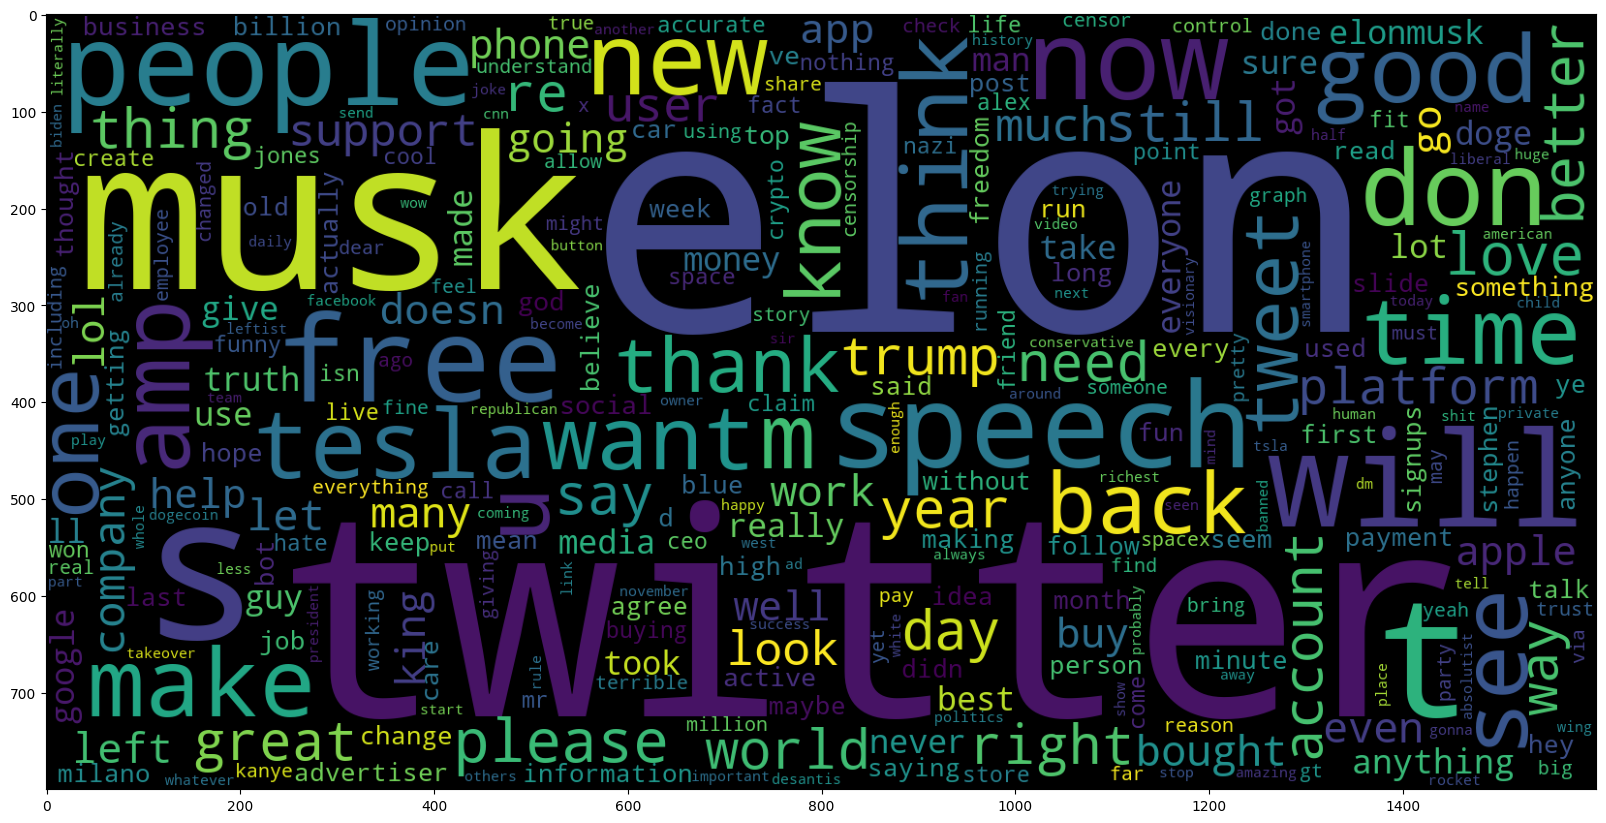

In [91]:
data_pos = tw_list_positive['text']
wc = WordCloud(max_words = 300 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

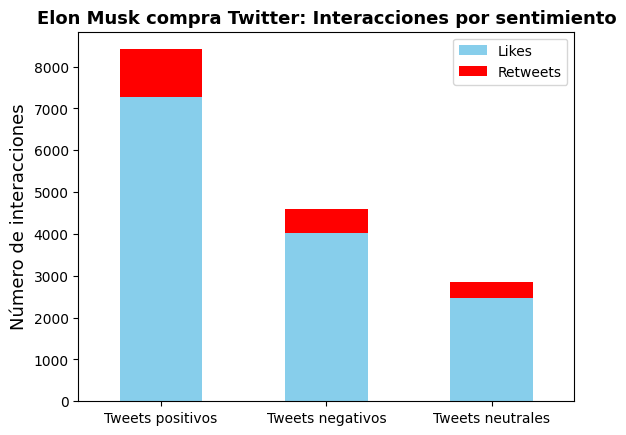

In [159]:
likes_per_sentiment = [tw_list[tw_list["sentiment"]=="positive"]['like_count'].sum(),
                       tw_list[tw_list["sentiment"]=="negative"]['like_count'].sum(),
                       tw_list[tw_list["sentiment"]=="neutral"]['like_count'].sum()]
rt_per_sentiment = [tw_list[tw_list["sentiment"]=="positive"]['retweet_count'].sum(),
                       tw_list[tw_list["sentiment"]=="negative"]['retweet_count'].sum(),
                       tw_list[tw_list["sentiment"]=="neutral"]['retweet_count'].sum()]
labels_sentiment = ['Tweets positivos', 'Tweets negativos', 'Tweets neutrales']

df_reactions = pd.DataFrame(list(zip(likes_per_sentiment, rt_per_sentiment)), index= labels_sentiment, columns = ['Likes', 'Retweets'])

# Creamos stacked chart
df_reactions.plot(kind='bar', stacked=True, color=['skyblue', 'red'])

plt.ylabel('Número de interacciones', fontsize=13)
 
plt.title('Elon Musk compra Twitter: Interacciones por sentimiento', fontsize=13, fontweight='bold')

plt.xticks(rotation=0)

plt.show()
